In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import base64
import json
from io import BytesIO
from glob import iglob

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from skimage import transform as tf
from skimage.color import rgb2gray
from skimage.io import imread
from IPython.display import HTML
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Conv2D,
    MaxPooling2D, AveragePooling2D, BatchNormalization,
)

pd.set_option('max_colwidth', -1)
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [3]:
def resize(img_array, size=400):
    h, w, c = img_array.shape
    padding_h = int((h-size) / 2)
    padding_w = int((w-size) / 2)
    return img_array[padding_h:padding_h + size, padding_w: padding_w + size]

labels_for_400 = [1,2,2,0,3,2,2,2,0,3,2,3,1,1,1,2,3,2,3,3,3,0,0,1,3,3,3,1,3,3,3,0,1]

def generate_data():
    for filepath, label in zip(iglob('./image/*'), labels_for_400):
        img = resize(imread(filepath))
        yield (rgb2gray(tf.resize(img, (32,32), mode='reflect')), label)

def gen_data():
    df = pd.DataFrame(generate_data())
    df.columns = ['x', 'y']
    test_data_df = df.groupby('y').head(2)
    train_data_df = df[~df.index.isin(test_data_df.index)]
    return np.expand_dims(np.stack(train_data_df.x), -1), np.stack(train_data_df.y), \
                np.expand_dims(np.stack(test_data_df.x), -1), np.stack(test_data_df.y)

In [4]:
img_tag_template = '<img src="data:image/png;base64,{}" />'
label_map = {
    0: '不明',
    1: '1',
    2: '2',    
    3: '3',
}
def to_base_64(image_array):
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    output = BytesIO()
    image.save(output, format='PNG')
    return base64.b64encode(output.getvalue()).decode()

def iter_data():
    df = pd.DataFrame(generate_data())
    df.columns = ['x', 'y']
    return pd.DataFrame({
        'image': df.x.apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
        'label': df.y.map(label_map),
    })

def iter_result(model):
    df = pd.DataFrame(generate_data())
    df.columns = ['x', 'y']
    y_pred = model.predict(np.expand_dims(np.stack(df.x), -1))
    return pd.DataFrame({
        'image': df.x.apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
        'label': df.y.map(label_map),
        'prediction': pd.Series(np.argmax(y_pred, axis=1)).map(label_map)
    })


,,0,1,2,3,4,5,6,7,8,9,10,11,12
label,,,,,,,,,,,,,,
1,image,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN
2,image,,,,,,,,,NaN,NaN,NaN,NaN,NaN
3,image,,,,,,,,,,,,,
不明,image,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

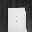
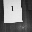
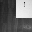
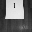
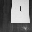
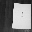
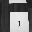
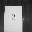
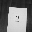
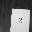
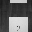
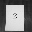
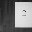
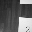
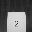
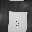
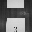
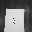
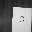
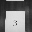
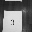
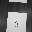
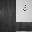
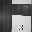
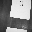
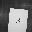
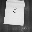
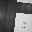
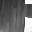
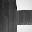
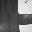
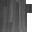
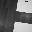

In [5]:
tmp_df = iter_data().groupby('label').apply(lambda df: df.reset_index()[['image']].transpose())
HTML(tmp_df.to_html(escape=False))

In [6]:
batch_size = 32
num_classes = 4
epochs = 10
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model.h5'

x_train, y_train, x_test, y_test = gen_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (25, 32, 32, 1)
25 train samples
8 test samples


In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25, 32, 32, 1), (25, 4), (8, 32, 32, 1), (8, 4))

In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(num_classes, (1, 1)))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(8, 8)))
model.add(Flatten())
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [10]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        zoom_range=[0.9, 1.1],
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4,
                        steps_per_epoch=100
                       )

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/10
100/100 [==============================] - 2s - loss: 1.2117 - acc: 0.4692 - val_loss: 1.3894 - val_acc: 0.2500
Epoch 2/10
100/100 [==============================] - 0s - loss: 1.0612 - acc: 0.5636 - val_loss: 1.3868 - val_acc: 0.3750
Epoch 3/10
100/100 [==============================] - 0s - loss: 0.9486 - acc: 0.7084 - val_loss: 1.3843 - val_acc: 0.5000
Epoch 4/10
100/100 [==============================] - 0s - loss: 0.8453 - acc: 0.7764 - val_loss: 1.3800 - val_acc: 0.5000
Epoch 5/10
100/100 [==============================] - 0s - loss: 0.7432 - acc: 0.8000 - val_loss: 1.1814 - val_acc: 0.5000
Epoch 6/10
100/100 [==============================] - 0s - loss: 0.6569 - acc: 0.8204 - val_loss: 0.6147 - val_acc: 0.7500
Epoch 7/10
100/100 [==============================] - 0s - loss: 0.5832 - acc: 0.8380 - val_loss: 0.3813 - val_acc: 1.0000
Epoch 8/10
100/100 [==============================] - 0s - loss: 0.5345 - acc: 0.8520 - val_loss: 0.3363

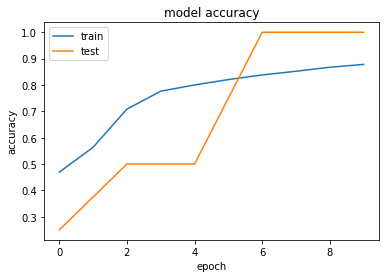

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

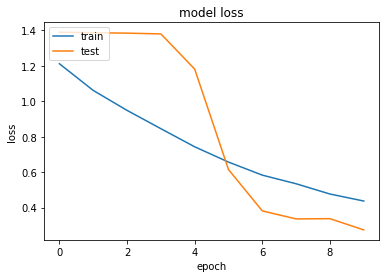

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

,image,label,pred
0,,1,1
1,,2,2
2,,2,2
3,,不明,不明
4,,3,3
5,,不明,不明
6,,3,3
7,,1,1

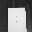
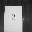
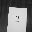
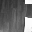
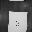
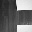
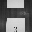
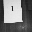

In [13]:
# result_df = iter_result(model)
y_pred = model.predict(x_test)
result_df = pd.DataFrame({
    'image': pd.Series([d[:,:,0] for d in x_test]).apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
    'label': pd.Series(np.argmax(y_test, axis=1)).map(label_map),
    'pred': pd.Series(np.argmax(y_pred, axis=1)).map(label_map)
})
HTML(result_df.to_html(escape=False))